# Compare observations of cloudtop SLF from Olimpia to those produced by NorESM
Using a modified micro_mg_cam.F90 that can be found in noresm_slf repo.

## Necessary Imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up directories based on where the program is being run from

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_olimpia/ct_slf_olimpia'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


List case to choose one of interest

In [3]:
all_cases = os.listdir('mnth15runs/')
all_cases.sort()
all_cases

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

Pick run to analyze

In [15]:
case = '20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100'

run_dir = 'mnth15runs/%s/' % case # inconsistent label compared to jupy_test
#run_dir = 'inp_validation/%s' % case
print(run_dir, os.path.exists(run_dir))

mnth15runs/20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100/ True


Ongoing list of variables of interest

In [16]:
relevant_vars = [
     'CLDFREE', 'CLDHGH','CLDICE', 'CLDLIQ', 'CLDLOW','CLDMED',
     'CLDTAU','CLDTOT','CLD_ISOTM','CLD_ISOTM_NONSIM','CLD_SLF',
     'CLD_SLF_NONSIM','CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
     'CONCLD', 'BERGO','BERGOXCLD_ISOTM','BERGOXCLD_ISOTM_NONSIM',
     'MG_SADICE','MG_SADLIQ','MNUCCCO','MNUCCDO','MNUCCDOhet',
     'MNUCCRO','MNUCCTO','NUMICE','NUMLIQ','NUMRAI','NUMSNO',
     'N_AER','PRECIPBINOCC_CC','PRECIPBINOCC_CL','PRECIPBINOCC_CT',
     'PRECIPBINRATE_CC','PRECIPBINRATE_CL','PRECIPBINRATE_CT', 
     'SADICEXCLD_ISOTM','SADICEXCLD_ISOTM_NONSIM','SADLIQXCLD_ISOTM',
     'SADLIQXCLD_ISOTM_NONSIM','SLFXCLD_ISOTM','SLFXCLD_ISOTM_NONSIM',
     'cell_weight', 'TS', 'CT_CLD_ISOTM',
     'CT_SLF', 'CT_SLFXCLD_ISOTM', 
     'AREI','FREQI','NUMICE','NUMICE10s','DSTFREZIMM', 'DSTFREZCNT',
     'DSTFREZDEP','NNUCCTO', 'NNUCCCO', 'NNUDEPO', 'NIHOMOO',
     'HOMOO','NIMIX_CNT','NIMIX_IMM','RELHUM','T','RHO_CLUBB'
    ]

This currently doesn't really work. WATT

Load cloudtop SLFs and construct global and regional averages and stds
This should be more flexible for arbitrary latitude ranges.

In [17]:
# Load NorESM data
try:
    _ds = xr.open_dataset('%s/%s.nc' % (run_dir,case))
except:
    _ds = xr.open_dataset('%s/atm/hist/%s.cam.h0.2000-01.nc' % (run_dir,case))
if (len(_ds['time']) > 1):
    try:
        ds = _ds.sel(time=slice('0001-04-01', '0002-03-01'))
    except:
        ds = _ds.sel(time=slice('2000-04-01', '2001-03-01'))
else:
    ds = _ds
ds = add_weights(ds) # still has time here

ds['CT_SLF'] = ds['CT_SLFXCLD_ISOTM']/ds['CT_CLD_ISOTM']
ct_slf_noresm = ds['CT_SLF']

ds['CT_SLF_ISOTM_AVG'] = ds['CT_SLF'].mean(dim = 'time', skipna=True)

# Load CALIOP data
ct_slf_caliop = xr.open_dataset('%s/cloudtop_slfs.nc' % obs_dir)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Define latitude ranges of interest.

In [18]:
slfvars = ['cell_weight', 'gw', 'TS', 'CT_SLF','CT_SLF_ISOTM_AVG','CT_SLFXCLD_ISOTM',
           'CT_CLD_ISOTM','SLFXCLD_ISOTM','CLD_ISOTM',
           'AREI','FREQI','NUMICE','NUMICE10s','DSTFREZIMM', 'DSTFREZCNT',
           'DSTFREZDEP', 'AWNI'] #,'NNUCCTO', 'NNUCCCO', 'NNUDEPO', 'NIHOMOO',
          # 'HOMOO','NIMIX_CNT','NIMIX_IMM','RELHUM','T','RHO_CLUBB']
doop = ds[slfvars]
try:
    del doop.attrs['_NCProperties'] # fixes a bug for some reasons: https://github.com/pydata/xarray/issues/2822
except:
    pass
doop.to_netcdf(path='%s/%s_slfvars.nc' % (run_dir,case))

In [19]:
bands = {'Global':[-90,90],'Arctic':[66.667,90],'Antarctic':[-90,-66.667],'CALIOP Arctic':[66.667,82]}
df = pd.DataFrame()

In [20]:
#df['isotherm'] = slf1['isotherm']
#df = df.set_index('isotherm')
for i in bands:
    _rng = bands[i]
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask1 = np.bitwise_or(ct_slf_caliop['lat']<_rng[0], ct_slf_caliop['lat']>_rng[1])
    mask2 = np.bitwise_or(ct_slf_noresm['lat']<_rng[0], ct_slf_noresm['lat']>_rng[1])
    
    weight1 = ct_slf_caliop['cell_weight']
    weight2 = ds['cell_weight'] #*ds['CT_CLD_ISOTM'] #Not sure about this
    
    slf1 = 100*masked_average(ct_slf_caliop['SLF'], dim=['lat','lon'],weights=weight1, mask=mask1)
    slf2 = 100*masked_average(ct_slf_noresm, dim=['lat','lon','time'],weights=weight2, mask=mask2)
    
    stdev1 = 100*np.std(ct_slf_caliop['SLF'].sel(lat=slice(_rng[0],_rng[1])), axis=(0,1))
    stdev2 = 100*np.std(ct_slf_noresm.sel(lat=slice(_rng[0],_rng[1])), axis=(0,2,3))
    
    df['CALIOP %s SLF' % i] = slf1
    df['CALIOP %s StDev' % i] = stdev1
    df['NorESM %s SLF' % i] = slf2
    df['NorESM %s StDev' % i] = stdev2
df['isotherm'] = slf1['isotherm']
df

,CALIOP Global SLF,CALIOP Global StDev,NorESM Global SLF,NorESM Global StDev,CALIOP Arctic SLF,CALIOP Arctic StDev,NorESM Arctic SLF,NorESM Arctic StDev,CALIOP Antarctic SLF,CALIOP Antarctic StDev,NorESM Antarctic SLF,NorESM Antarctic StDev,CALIOP CALIOP Arctic SLF,CALIOP CALIOP Arctic StDev,NorESM CALIOP Arctic SLF,NorESM CALIOP Arctic StDev,isotherm
0,2.652094,5.807777,3.104181,13.665764,2.448328,2.686922,6.407087,16.817947,4.095303,4.009299,7.833691,18.843517,2.448328,2.686922,6.621545,17.919109,-40.0
1,16.110721,16.863898,17.413728,33.894695,11.182338,6.798517,24.477177,33.652237,29.083648,11.664116,41.722763,43.752869,11.182338,6.798517,26.199034,36.652252,-35.0
2,48.726922,26.783687,26.505299,40.720688,39.743815,11.886540,51.364678,44.053997,76.344829,9.706979,67.250245,41.763218,39.743815,11.886540,53.183599,42.945038,-30.0
3,68.557867,23.702292,41.087817,43.211426,66.755759,9.768171,81.126948,35.119148,84.836145,16.758521,83.100610,31.262960,66.755759,9.768171,81.117577,31.797647,-25.0
4,82.848191,18.481084,51.579393,41.298519,86.842881,6.023320,92.525073,16.196465,90.111826,17.041121,94.276016,16.689175,86.842881,6.023320,91.653402,18.978088,-20.0
5,89.782925,14.106420,65.540290,36.218636,94.521922,3.525254,95.573683,11.630255,94.810568,13.430821,98.633826,6.622959,94.521922,3.525254,94.975633,14.258249,-15.0
6,90.960496,13.894029,68.222683,35.104153,96.992953,3.093767,98.407981,5.866838,95.970086,13.618475,99.914845,1.325538,96.992953,3.093767,98.197318,7.292079,-10.0
7,91.791636,14.734814,86.147276,24.878540,97.131304,5.642598,99.738448,1.901949,96.772004,11.817037,99.962543,0.073658,97.131304,5.642598,99.709794,2.311191,-5.0
8,96.874805,9.863054,94.877659,15.369958,98.369610,5.955775,99.985151,0.120369,96.684488,15.223417,99.997636,0.006785,98.369610,5.955775,99.983699,0.142269,0.0


In [21]:
data_string = '%s%scloudtop_slf_comparison.csv' % (run_dir, case)
df.to_csv(path_or_buf = data_string)

Text(0.5,0.98,'20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100')

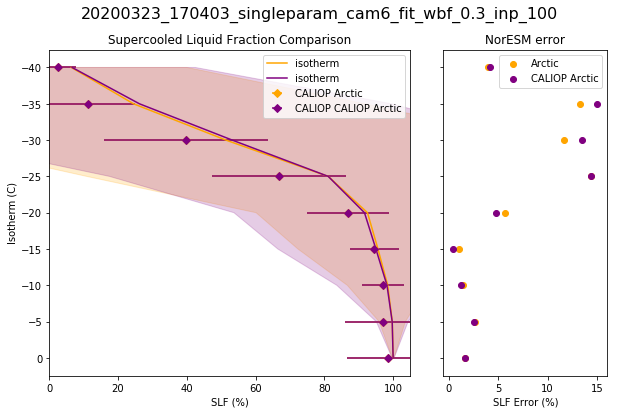

In [22]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
axes = [f1_ax1, f1_ax2]
plt.setp(f1_ax2.get_yticklabels(), visible=False)

#isos = np.array(all_slf_clean.index).reshape(-1,1)

fig1.gca().invert_yaxis()
f1_ax1.set_title('Supercooled Liquid Fraction Comparison'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

colors = ['blue', 'orange', 'red', 'purple']

for b,c in zip(bands, colors):
    if (b == 'Arctic' or b == 'CALIOP Arctic'):
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)

Text(0.5,0.98,'20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100')

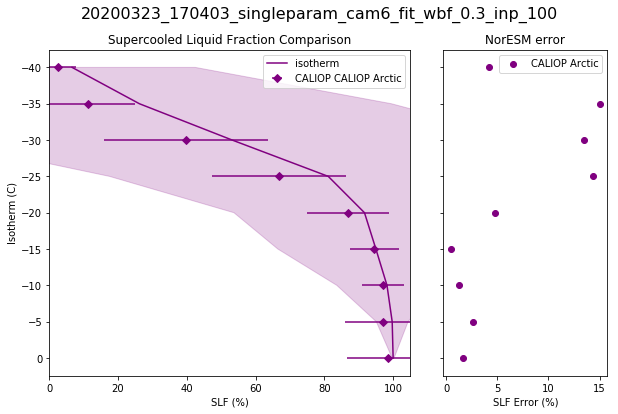

In [23]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
axes = [f1_ax1, f1_ax2]
plt.setp(f1_ax2.get_yticklabels(), visible=False)

#isos = np.array(all_slf_clean.index).reshape(-1,1)

fig1.gca().invert_yaxis()
f1_ax1.set_title('Supercooled Liquid Fraction Comparison'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

colors = ['blue', 'orange', 'red','purple']
#print(bands)
for b,c in zip(bands, colors):
    if b == 'CALIOP Arctic':
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)

In [13]:
filename = '%s_slf_comparison.png' % case
filename
if not os.path.exists(filename):
    fig1.savefig(run_dir + filename,format = 'png', dpi = 200)
    fig1.clf()

Plot the global SLF at each isotherm

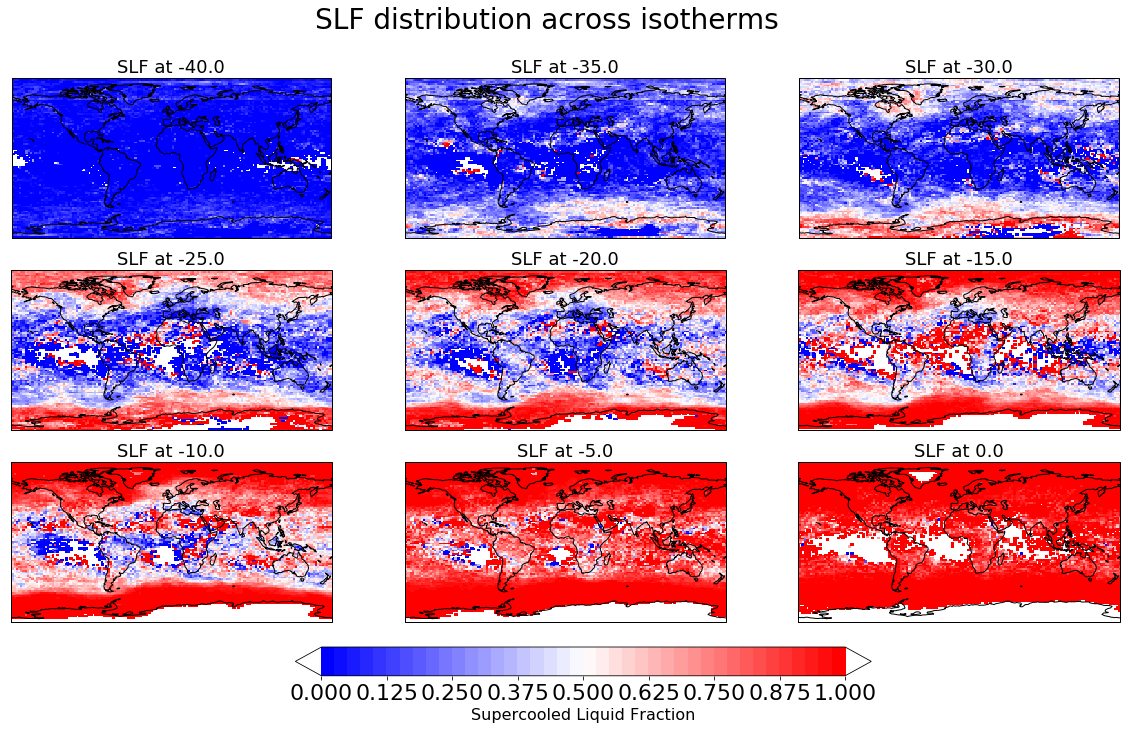

In [14]:
iso_fig = plot_slf_isotherms(ds)

In [39]:
filename = '%s_noresm_slf_isotherms.png' % case
filename
if not os.path.exists(filename):
    iso_fig.savefig(run_dir + filename,format = 'png', dpi = 200)
    iso_fig.clf()

# TRash!